In [1]:
#clone repository until final version of package is released
!git clone https://github.com/oskarfernlund/niteshade.git
%cd 'niteshade/'

#necessary installs
!pip install fpdf
#!pip install niteshade

Cloning into 'niteshade'...
remote: Enumerating objects: 2663, done.
remote: Counting objects: 100% (569/569), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 2663 (delta 398), reused 525 (delta 356), pack-reused 2094
Receiving objects: 100% (2663/2663), 25.78 MiB | 21.05 MiB/s, done.
Resolving deltas: 100% (1889/1889), done.
/content/niteshade
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40725 sha256=d13e1ad4bdc13ce54f1703a1fbbd5b1c1e71b70959c1c340d0003768e6d7e27b
  Stored in directory: /root/.cache/pip/wheels/d7/ca/c8/86467e7957bbbcbdf4cf4870fc7dc95e9a16404b2e3c3a98c3
Successfully built fpdf


# Import Necessary Libraries

In [2]:
#necessary imports
import numpy as np
import torch

from niteshade.attack import AddLabeledPointsAttacker, LabelFlipperAttacker, BrewPoison
from niteshade.defence import FeasibleSetDefender, KNN_Defender, SoftmaxDefender
from niteshade.models import MNISTClassifier, CifarClassifier, BaseModel
from niteshade.postprocessing import PostProcessor
from niteshade.simulation import Simulator, wrap_results
from niteshade.utils import train_test_iris, train_test_MNIST, train_test_cifar
from niteshade.data import DataLoader

# Using the **niteshade** Pipeline to Test Attack and Defense Strategies on an Off The Shelf ResNet-18 CIFAR10 Classifier

In [3]:
#load CIFAR10 data
X_train, y_train, X_test, y_test, X_val, y_val = train_test_cifar(val_size=0.2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets/
Files already downloaded and verified


In [13]:
torch.manual_seed(0) #seed for reproducibility

BATCH_SIZE = 32 # --> mini-batches on which model is trained on
NUM_EPISODES = 10 # --> number of times the attacker/defender intervene

#define model and simulator
model = CifarClassifier()

#BrewPoison Attacker vs KNN Defender (NEED TO TUNE THEIR PARAMETERS)
attacker = BrewPoison(3)
#defender = KNN_Defender(X_train, y_train, nearest_neighbours=3, confidence_threshold=0.7)
defender = FeasibleSetDefender(X_val, y_val, threshold=5000)

#define simulator
simulator = Simulator(X_train, y_train, model=model, attacker=attacker,
                      defender=defender, batch_size=BATCH_SIZE, num_episodes=NUM_EPISODES)

#running the simulation once is equivalent to training the model on 
#the whole dataset (X_train,y_train) passed in the constructor method
simulator.run(attacker_requires_model=True)

#calculate the accuracy on the validation set to prevent overfitting
accuracy = model.evaluate(X_val, y_val, BATCH_SIZE)
print("VALIDATION ACCURACY = {:.2f}%".format(accuracy))

Running simulation: 100%|██████████| 10/10 [00:40<00:00,  4.04s/episode, loss=0.0311]


VALIDATION ACCURACY = 63.98%


In [14]:
#evaluate on the held out test set
accuracy = model.evaluate(X_test, y_test, BATCH_SIZE)
print("TEST ACCURACY = ", accuracy, "%")

TEST ACCURACY =  65.12419871794872 %


## **PostProcessor Functionalities**

100%|██████████| 1/1 [00:23<00:00, 23.12s/it]


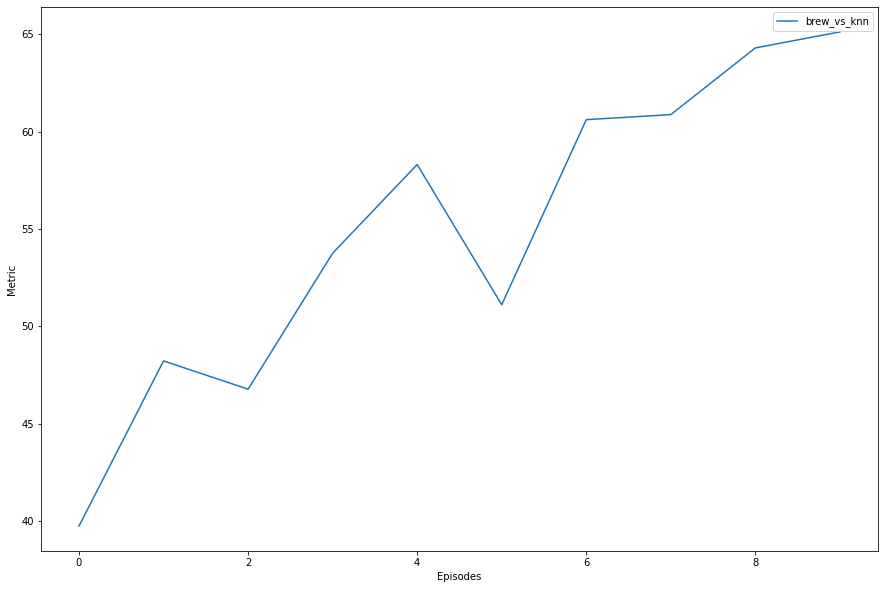

In [15]:
simulators = {"brew_vs_knn": simulator} # --> define dict with keys as descriptions of simulations
pp = PostProcessor(simulators) # --> postprocessor object with simulators dict as arguments

#plot test accuracies throughout online learning
metrics = pp.compute_online_learning_metrics(X_test, y_test)
pp.plot_online_learning_metrics(metrics, show_plot=False, save=True, 
                                plotname='test_accuracies', set_plot_title=False)

In [16]:
#visualise attacker and defender interventions
data_modifications = pp.track_data_modifications()
print(data_modifications)

                      brew_vs_knn
modified_by_defender            0
poisoned_by_attacker        33784
removed_by_defender             0


# End-to-end Example on an MNIST Classifier

In [3]:
# batch size
BATCH_SIZE = 128
NUM_EPISODES = 30
#split iris dataset into train and test
X_train, y_train, X_test, y_test = train_test_MNIST()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



In [4]:
defender = FeasibleSetDefender(X_train, y_train, 2000)
label_flips_dict = {1:9, 9:1}
attacker = LabelFlipperAttacker(1, label_flips_dict)
#attacker = SimpleAttacker(0.6, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTClassifier()
model = model.to(device) #send model to device

simulator1 = Simulator(X_train, y_train, model, attacker=attacker,
                    defender=None, batch_size=BATCH_SIZE, num_episodes=NUM_EPISODES)

model = MNISTClassifier()
model = model.to(device) #send model to device
simulator2 = Simulator(X_train, y_train, model, attacker=None,
                    defender=None, batch_size=BATCH_SIZE, num_episodes=NUM_EPISODES)

model = MNISTClassifier()
model = model.to(device) #send model to device
simulator3 = Simulator(X_train, y_train, model, attacker=None,
                    defender=defender, batch_size=BATCH_SIZE, num_episodes=NUM_EPISODES)

model = MNISTClassifier()
model = model.to(device) #send model to device
simulator4 = Simulator(X_train, y_train, model, attacker=attacker,
                    defender=defender, batch_size=BATCH_SIZE, num_episodes=NUM_EPISODES)


#simulate attack and defense separately using class method
simulator1.run()
simulator2.run()
simulator3.run()
simulator4.run()    

simulators = {'only_attacker': simulator1, 'regular': simulator2,
                'attacker_and_defender': simulator4}

Running simulation: 100%|██████████| 30/30 [00:02<00:00, 10.13episode/s, loss=0.00143]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


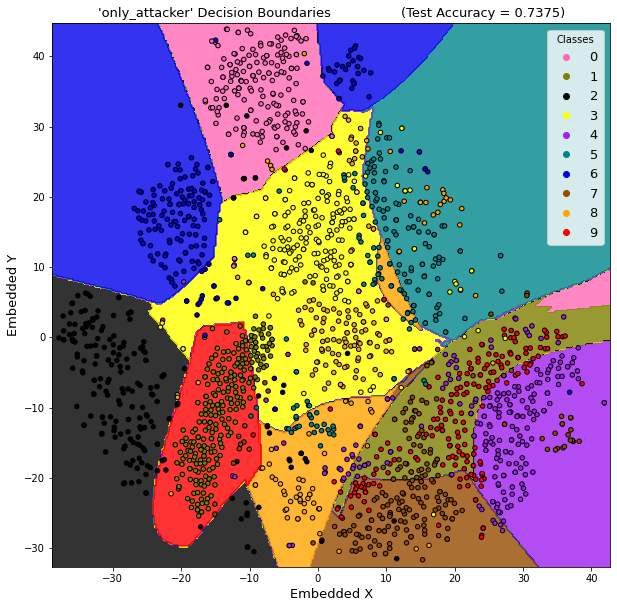

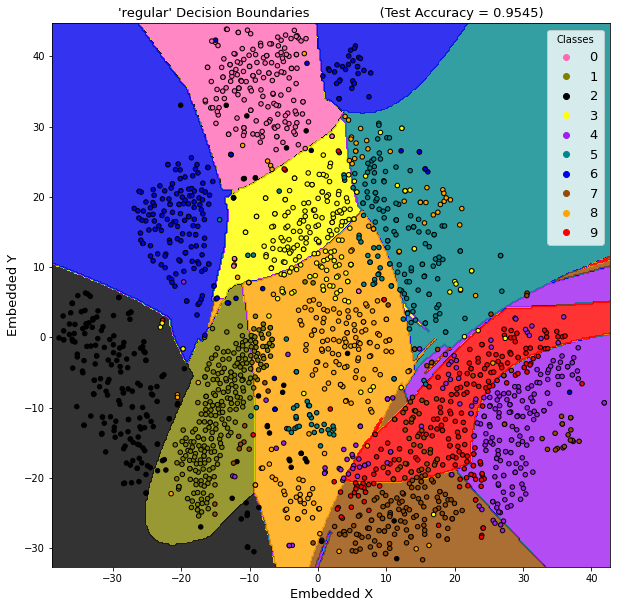

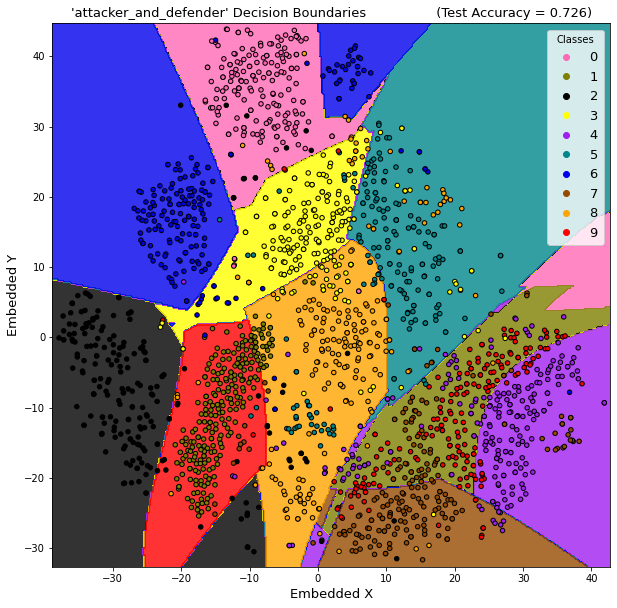

In [5]:
pp = PostProcessor(simulators)
pp.plot_decision_boundaries(X_test, y_test, num_points = 2000, perplexity=100, 
                                        n_iter=2000, fontsize=13, markersize=20, figsize=(10,10), 
                                        resolution=0.2, save=True, show_plot=False)

In [6]:
# Get point counts for each simulation
data_modifications = pp.track_data_modifications()

100%|██████████| 3/3 [00:12<00:00,  4.02s/it]


{'only_attacker': [array(36.708733, dtype=float32), array(60.13622, dtype=float32), array(64.44311, dtype=float32), array(67.00721, dtype=float32), array(68.46955, dtype=float32), array(70.84335, dtype=float32), array(72.71635, dtype=float32), array(71.895035, dtype=float32), array(72.495995, dtype=float32), array(72.20553, dtype=float32), array(73.19711, dtype=float32), array(73.357376, dtype=float32), array(73.12701, dtype=float32), array(73.71795, dtype=float32), array(73.81811, dtype=float32), array(74.2488, dtype=float32), array(74.52925, dtype=float32), array(74.39904, dtype=float32), array(73.878204, dtype=float32), array(75.23037, dtype=float32), array(74.559296, dtype=float32), array(75.020035, dtype=float32), array(74.50922, dtype=float32), array(74.77965, dtype=float32), array(75.30048, dtype=float32), array(75.30048, dtype=float32), array(75.250404, dtype=float32), array(75.42068, dtype=float32), array(75.200325, dtype=float32), array(74.9399, dtype=float32)], 'regular': [a

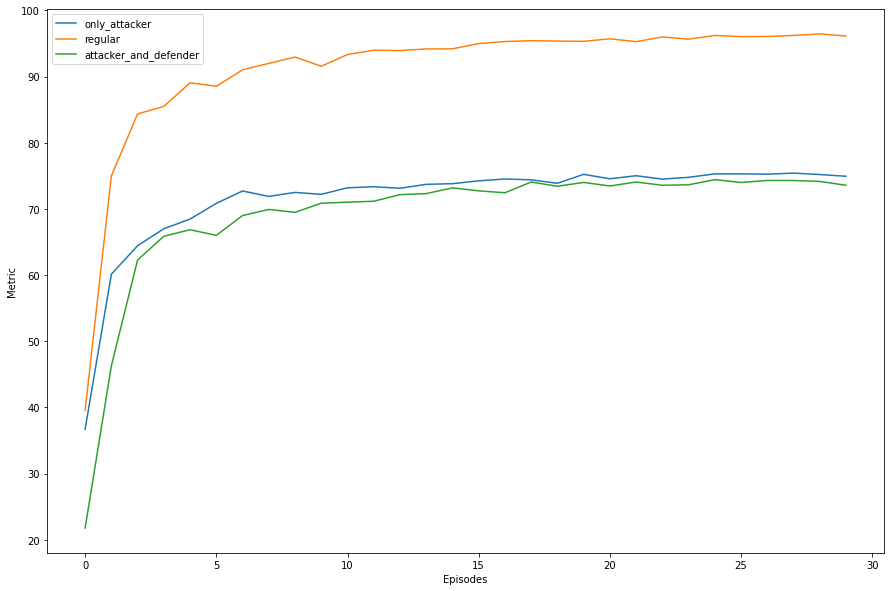

In [7]:
# Save the accruacy plot
metrics = pp.compute_online_learning_metrics(X_test, y_test)
print(metrics)
pp.plot_online_learning_metrics(metrics, show_plot=False, save=True, 
                                plotname='test_accuracies', set_plot_title=False)